## Import Libraries

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import librosa

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

import keras
from keras import regularizers
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization, Activation, GlobalAveragePooling1D
from sklearn.metrics import confusion_matrix, classification_report
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint

from IPython.display import Audio
# import resampy

## Extract Data

In [ ]:
path = "kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24"

In [ ]:
#happens sometimes 
#if '.DS_Store' in os.listdir("data"):
#    os.remove('data/.DS_Store')

    
#extract file values 
directory_list = os.listdir(path)

file_emotion = []
file_path = []
file_gender = []
file_intensity = []
file_line = []


for dir in directory_list:
    
    # as their are 24 different actors in our previous directory we need to extract files for each actor.
    actor = os.listdir(os.path.join(path,dir))
    
    for file in actor:
        part = file.split('.')
        part = part[0].split('-')
        # third part in each file represents the emotion associated to that file.
        file_emotion.append(int(part[2]))
        file_intensity.append(0 if int(part[3]) == 1 else 1) #0 is normal and 1 is strong
        file_line.append("Kids are talking by the door" if int(part[4]) == 1 else "Dogs are sitting by the door")
        file_path.append(os.path.join(path,dir,file))
        file_gender.append(0 if int(dir.split('_')[1]) %2 == 1 else 1) #0 is male and 1 is female
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])

# dataframe for gender of actor
gender_df = pd.DataFrame(file_gender, columns=['Gender'])

#dataframe for emotional intensity
intensity_df = pd.DataFrame(file_intensity, columns=['Intensity'])

#dataframe for sentences spoken
line_df = pd.DataFrame(file_line, columns=['Line'])


#main df
df = pd.concat([path_df, emotion_df, gender_df, intensity_df, line_df], axis=1)

# changing integers to actual emotions.
df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
df.to_csv("data_clean.csv")

df.head()

### Read file
Use `head` and `tail` to retrieve the top and bottom `n` rows. Use `sample` to randomly view `5` rows

In [ ]:
df = pd.read_csv("data_clean.csv")
df.head()

In [ ]:
df.tail()

In [ ]:
df.sample(5)

In [ ]:
df.isna().sum()

### Summary Statistics

In [ ]:
df[["Gender","Intensity","Emotions"]].describe(include="all")

### Data distribution

In [ ]:
df["Emotions"].value_counts().plot(kind='bar',color={'red','blue','green','orange','yellow','purple','indigo','turquoise'})

In [ ]:
sns.countplot(x='Emotions', hue='Gender', data=df) #ax
plt.xlabel('Emotions')
plt.ylabel('Count')
plt.title('Distribution of Emotions by Gender')
plt.legend(title='Gender', loc='upper right', labels=['Male','Female'])  
plt.show()

# Display count values on top of the bars
# for p in ax.patches:
#     ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='baseline')


df[['Emotions', 'Gender', 'Intensity']].value_counts()
# df['Line'].value_counts()

Data is evenly distributed except "Neutral" emotion has half the number of samples as there is no "Strong" emotional intensity for "Neutral" 

### View Waveforms

In [ ]:
#helper functions
def create_waveform(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Amplitude waveform for audio with {} emotion'.format(e), size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.show()
        

def create_spectrogram(data, sr, e): #use mel-spectro instead?
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram (Pitch) for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log') #log is better for differentiating - mel-spectrogram
    plt.colorbar()
        

#df is global variable
def show(emotion):
    path = np.array(df.Path[df.Emotions==emotion])[1]
    data, sampling_rate = librosa.load(path)
    create_waveform(data, sampling_rate, emotion)
    create_spectrogram(data, sampling_rate, emotion)
    display(Audio(path))

In [ ]:
all_emotions = df['Emotions'].unique()
for emotion in all_emotions:
    show(emotion)

### Comparitive MFCC waveform

In [ ]:
# generates line plot of mean pitch 

def amp_wave(emotion, gender):
    path = df[(df['Emotions'] == emotion) & (df['Gender'] == gender)]['Path'].iloc[1]
    X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5) 
    fig = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)
    fig = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
    return fig

In [ ]:
plt.figure(figsize=(15, 12))
plt.subplots_adjust(hspace=0.5)
plt.suptitle("Emotion", fontsize=18, y=0.95)
nrows = round(len(all_emotions)/2)

for i, emotion in enumerate(all_emotions):
    # add a new subplot iteratively
    ax = plt.subplot(nrows, 2, i + 1)

    plt.plot(amp_wave(emotion, 0),  label='male')
    plt.plot(amp_wave(emotion, 1),  label='female')
    plt.legend()
    ax.set_title(emotion)


## Amplitude Envelope Feature


In [ ]:
def amplitude_envelope(emotion, frame_size, hop_len, visualise=True):
    path = np.array(df.Path[df.Emotions==emotion])[1]
    signal, sr = librosa.load(path)
    ae = np.array([max(signal[i:i+frame_size]) for i in range(0, len(signal), hop_len)])
    
    frames = range(0, len(ae))
    times = librosa.frames_to_time(frames, hop_length = hop_len)
    
    if visualise == True:
        plt.figure(figsize=(10,6))
        librosa.display.waveshow(signal, alpha=0.5)
        plt.plot(times, ae, color='r')
        plt.title(emotion + " Amplitude Envelope")
        plt.show()
    
    return ae


In [ ]:
all_emotions = df['Emotions'].unique()
for emotion in all_emotions:
    amplitude_envelope(emotion, frame_size=2048, hop_len=512)

Other metrics for amplitude
- root mean square energy
- zero crossing rate

And other metrics here 

- https://towardsdatascience.com/extract-features-of-music-75a3f9bc265d
- https://jonathan-hui.medium.com/speech-recognition-feature-extraction-mfcc-plp-5455f5a69dd9

In [ ]:
path = np.array(df.Path)[1]
data, sample_rate = librosa.load(path)

# Data Augmentation

In [ ]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(y=data, rate=rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(y=data, sr=sampling_rate, n_steps=pitch_factor)

In [ ]:
x = pitch(data, sample_rate)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

# Feature Extraction

In [ ]:
# from pyAudioAnalysis import audioBasicIO
# from pyAudioAnalysis import MidTermFeatures
# import matplotlib.pyplot as plt

# path = df.at[30, "Path"]
# print(df.at[30, "Emotions"])
# test = np.array([])
# [Fs, x] = audioBasicIO.read_audio_file(path)
# F,Fshort, f_names = MidTermFeatures.mid_feature_extraction(x, Fs, 0.50*Fs, 0.25*Fs, 0.050*Fs, 0.025*Fs)

# #Extract features 1-21, 34
# for f in F[:20]+F[33]:
#     #Stack/stitch 12 frames together
#     f = f[12//2-6:12//2+6]
#     test = np.hstack((test,f))
    


In [ ]:



# def extract_features(data, sample_rate):
#     print(sample_rate)
#     # ZCR
#     result = np.array([])
#     F,Fshort, f_names = MidTermFeatures.mid_feature_extraction(data, sample_rate, 0.50*sample_rate, 0.25*sample_rate, 0.050*sample_rate, 0.025*sample_rate)
#     #Extract features 1-21, 34
#     for f in F[:20]+F[33]:
#         #Stack/stitch 12 frames together
#         f = f[12//2-6:12//2+6]
#         result = np.hstack((result,f))
#     return result


# def get_features(path):
#     # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
#     sample_rate, data = audioBasicIO.read_audio_file(path)
#     print(sample_rate)
#     # without augmentation
#     res1 = extract_features(data,sample_rate)
#     result = np.array(res1)
    
#     # data with noise
#     noise_data = noise(data)
#     res2 = extract_features(noise_data,sample_rate)
#     result = np.vstack((result, res2)) # stacking vertically
    
#     # data with stretching and pitching
#     # new_data = stretch(data)
#     # data_stretch_pitch = pitch(new_data, sample_rate)
#     # res3 = extract_features(data_stretch_pitch,sample_rate)
#     # result = np.vstack((result, res3)) # stacking vertically
    
#     return result



def extract_features(data, sample_rate):
    result = np.array([])

    # # ZCR
    # zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    # result = np.hstack((result, zcr))

    # # Chroma_stft
    # stft = np.abs(librosa.stft(data))
    # chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    # result = np.hstack((result, chroma_stft))

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc))

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms))

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel))
    
    # Spectral Centroid
    spectral_centroids = np.mean(librosa.feature.spectral_centroid(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, spectral_centroids))

    # Spectral Bandwidth
    spectral_bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, spectral_bandwidth))

    # Spectral Contrast
    spectral_contrast = np.mean(librosa.feature.spectral_contrast(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, spectral_contrast))

    # Spectral Rolloff
    spectral_rolloff = np.mean(librosa.feature.spectral_rolloff(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, spectral_rolloff))

    # Chroma Deviation
    chroma_std = np.std(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_std))

    return result

def get_features(path):
    hstack = None
    step = 5
    for i in range(0,30,step):
        
        if i == 0:
            offset=0
        else:
            i/=10
            offset = i-step/10
        print(i,offset)
        # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
        data, sample_rate = librosa.load(path, offset=offset, duration=step/10)
        print(data)
    
        # without augmentation
        res1 = extract_features(data,sample_rate)
        result = np.array(res1)
        
        # data with noise
        noise_data = noise(data)
        res2 = extract_features(noise_data,sample_rate)
        result = np.vstack((result, res2)) # stacking vertically
        
        # data with stretching and pitching
        new_data = stretch(data)
        data_stretch_pitch = pitch(new_data, sample_rate)
        res3 = extract_features(data_stretch_pitch,sample_rate)
        result = np.vstack((result, res3)) # stacking vertically
        
        if i == 0:
            hstack = result
        else: hstack = np.hstack((hstack,result))
        print(hstack.shape)
        
    return hstack

In [ ]:
X, Y = [], []
for path, emotion in zip(df.Path, df.Emotions):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)

In [ ]:
len(X), len(Y), df.Path.shape

In [90]:
# Features = pd.DataFrame(X)
# Features['labels'] = Y
# Features.to_csv('features2.csv', index=False)

Features = pd.read_csv("features2.csv")

# Features.head()

# Data Preparation

In [118]:
Features = pd.read_csv("features2.csv")
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [119]:
# As this is a multiclass classification problem onehotencoding our Y.
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [120]:
# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3240, 1104), (3240, 8), (1080, 1104), (1080, 8))

In [121]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3240, 1104), (3240, 8), (1080, 1104), (1080, 8))

In [122]:
# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3240, 1104, 1), (3240, 8), (1080, 1104, 1), (1080, 8))

# Modelling

In [123]:

model = Sequential()

# Convolutional Layer
model.add(Conv1D(128, 5, padding='same',
                 input_shape=(x_train.shape[1], 1),
                 kernel_regularizer=regularizers.l1_l2(l1=0.0001, l2=0.0001)))
model.add(Activation('relu'))
model.add(Dropout(0.3))

# Global Average Pooling
model.add(Flatten())

# Dense Layer with Batch Normalization
model.add(Dense(8, kernel_regularizer=regularizers.l1_l2(l1=0.0005, l2=0.001)))
model.add(Activation('softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_18 (Conv1D)          (None, 1104, 128)         768       
                                                                 
 activation_32 (Activation)  (None, 1104, 128)         0         
                                                                 
 dropout_16 (Dropout)        (None, 1104, 128)         0         
                                                                 
 flatten_16 (Flatten)        (None, 141312)            0         
                                                                 
 dense_16 (Dense)            (None, 8)                 1130504   
                                                                 
 activation_33 (Activation)  (None, 8)                 0         
                                                                 
Total params: 1,131,272
Trainable params: 1,131,272
N

In [124]:
import tensorflow as tf
print(tf.test.is_built_with_cuda())
# print(tf.test.is_built_with_cudnn())

True


In [125]:
epochs = 300
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.9, verbose=0, patience=2, min_lr=0.0001)
history=model.fit(x_train, y_train, batch_size=350, epochs=epochs, validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/300
10/10 [==============================] - 1s 34ms/step - loss: 3.0786 - accuracy: 0.3605 - val_loss: 3.3092 - val_accuracy: 0.4843 - lr: 0.0010
Epoch 2/300
10/10 [==============================] - 0s 18ms/step - loss: 2.1714 - accuracy: 0.5904 - val_loss: 2.2499 - val_accuracy: 0.6120 - lr: 0.0010
Epoch 3/300
10/10 [==============================] - 0s 18ms/step - loss: 1.8361 - accuracy: 0.6688 - val_loss: 1.8684 - val_accuracy: 0.6417 - lr: 0.0010
Epoch 4/300
10/10 [==============================] - 0s 18ms/step - loss: 1.6201 - accuracy: 0.7145 - val_loss: 1.9439 - val_accuracy: 0.6639 - lr: 0.0010
Epoch 5/300
10/10 [==============================] - 0s 17ms/step - loss: 1.5098 - accuracy: 0.7160 - val_loss: 1.8776 - val_accuracy: 0.6694 - lr: 0.0010
Epoch 6/300
10/10 [==============================] - 0s 18ms/step - loss: 1.4421 - accuracy: 0.7420 - val_loss: 1.8321 - val_accuracy: 0.6907 - lr: 0.0010
Epoch 7/300
10/10 [==============================] - 0s 18ms/step - lo

34/34 [==============================] - 0s 4ms/step - loss: 0.8145 - accuracy: 0.8491
Accuracy of our model on test data :  84.90740656852722 %
300
300
300


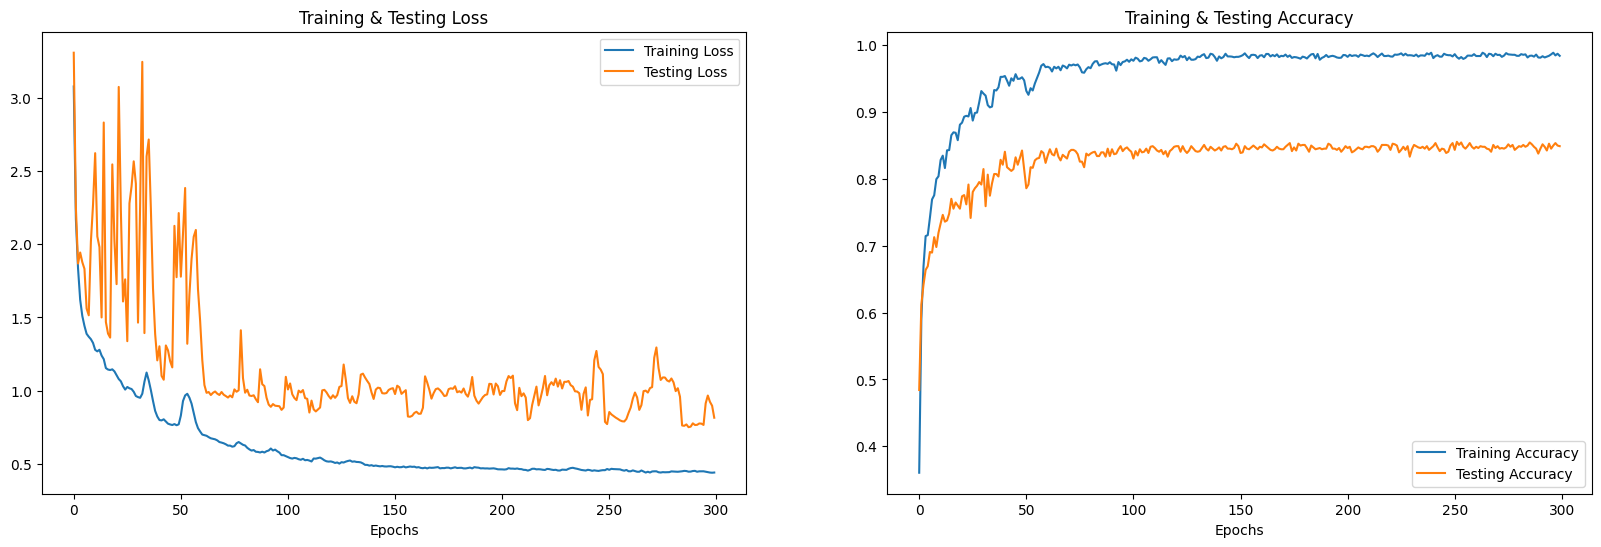

In [128]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(epochs)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

print(len(train_loss))
print(len(test_acc))
print(len(test_loss))


fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [141]:
# predicting on test data.
pred_test = model.predict(x_test)
# print(pred_test)

pred_list = []
categories = [category for category in encoder.categories_][0]
for preds in pred_test:
    pred_dict = {}
    for cat,pred in zip(categories,preds):
        pred_dict[cat]=pred
    pred_list.append(pred_dict)
print(pred_list)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

34/34 [==============================] - 0s 8ms/step
[{'angry': 0.00042405515, 'calm': 5.3557887e-05, 'disgust': 0.000113621696, 'fear': 0.9398717, 'happy': 0.03163053, 'neutral': 0.0017929308, 'sad': 0.01854285, 'surprise': 0.007570672}, {'angry': 0.9683649, 'calm': 0.00012692937, 'disgust': 0.01866782, 'fear': 0.0034869427, 'happy': 0.008218813, 'neutral': 0.00010999014, 'sad': 0.0009058438, 'surprise': 0.00011867346}, {'angry': 0.00077670853, 'calm': 3.2250949e-09, 'disgust': 2.6405971e-06, 'fear': 0.5512694, 'happy': 0.39501643, 'neutral': 0.00014192423, 'sad': 0.0040526357, 'surprise': 0.048740327}, {'angry': 1.2372222e-05, 'calm': 0.95873433, 'disgust': 0.0009253765, 'fear': 4.2818403e-05, 'happy': 1.955097e-05, 'neutral': 0.04018504, 'sad': 7.073019e-05, 'surprise': 9.887362e-06}, {'angry': 0.9785598, 'calm': 4.0405625e-06, 'disgust': 0.0006541231, 'fear': 0.0034887763, 'happy': 0.010651532, 'neutral': 0.0037225252, 'sad': 0.00286254, 'surprise': 5.6557234e-05}, {'angry': 0.0048

ValueError: could not convert string to float: 'fear'

In [134]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(20)

,Predicted Labels,Actual Labels
0,fear,fear
1,angry,angry
2,fear,fear
3,calm,calm
4,angry,angry
5,surprise,surprise
6,fear,fear
7,happy,happy
8,fear,fear
9,sad,sad


[array(['angry', 'calm', 'disgust', 'fear', 'happy', 'neutral', 'sad',
       'surprise'], dtype=object)]


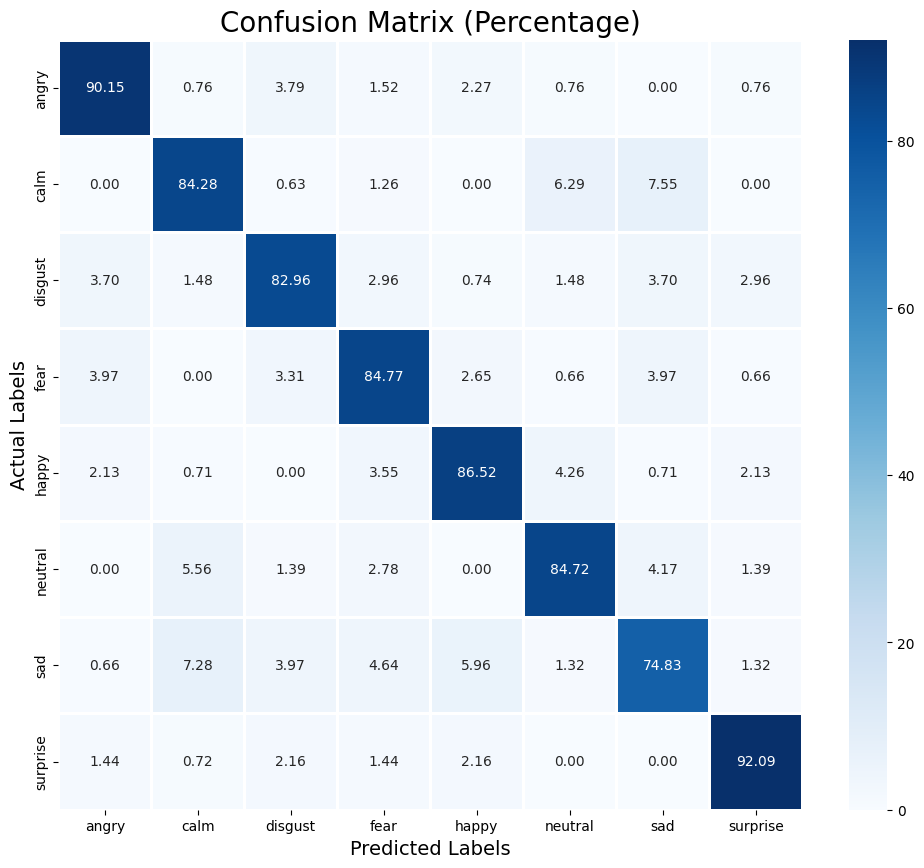

In [131]:
cm = confusion_matrix(y_test, y_pred)

# Normalize the confusion matrix.
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize = (12, 10))

# Convert categories of the encoder to a list for indexing and columns
categories = [category for category in encoder.categories_]
print(categories)
cm_df = pd.DataFrame(cm_percentage, index=categories, columns=categories)
sns.heatmap(cm_df, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='.2f')

plt.title('Confusion Matrix (Percentage)', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [132]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.88      0.90      0.89       132
        calm       0.87      0.84      0.86       159
     disgust       0.84      0.83      0.84       135
        fear       0.84      0.85      0.84       151
       happy       0.86      0.87      0.86       141
     neutral       0.73      0.85      0.79        72
         sad       0.81      0.75      0.78       151
    surprise       0.91      0.92      0.92       139

    accuracy                           0.85      1080
   macro avg       0.84      0.85      0.85      1080
weighted avg       0.85      0.85      0.85      1080



In [143]:
model.save("models/cnn/sam_280923_v2.h5")